In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from finance.utilities import utils, financial_utils, time_series_utils

## Stocks

In [2]:
query = """
    select 
        e.symbol
        , e.market_datetime
        , e.open
        , e.high
        , e.low
        , e.close
        , e.volume
        , f.high_52
        , f.low_52
        , f.dividend_amount
        , f.pe_ratio
        , f.quick_ratio
        , f.current_ratio
    from td.equities as e
    left join td.fundamentals as f 
        on f.symbol = e.symbol
    where e.symbol = 'BA'
    order by e.market_datetime
    """

df = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)
df.head()

,symbol,market_datetime,open,high,low,close,volume,high_52,low_52,dividend_amount,pe_ratio,quick_ratio,current_ratio
0,BA,1999-09-03 05:00:00,45.1875,45.6250,45.1875,45.4375,2191300.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
1,BA,1999-09-07 05:00:00,45.4375,45.6250,44.8750,44.9375,1906600.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
2,BA,1999-09-08 05:00:00,44.8125,44.8125,44.3125,44.5625,2095200.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
3,BA,1999-09-09 05:00:00,44.5625,45.2500,44.3750,45.1250,2109000.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
4,BA,1999-09-10 05:00:00,45.1250,45.7500,44.8750,45.2500,1724900.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317


### Time series

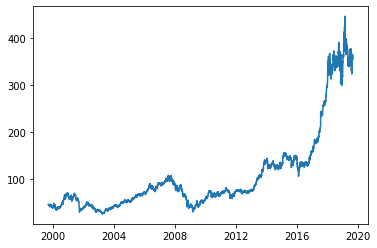

In [3]:
plt.plot(df['market_datetime'], df['open'])
plt.show()

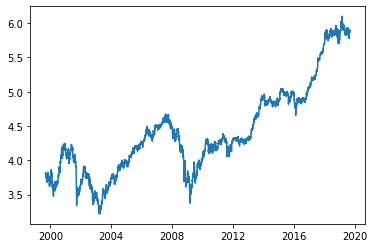

In [4]:
plt.plot(df['market_datetime'], np.log(df['open']))
plt.show()

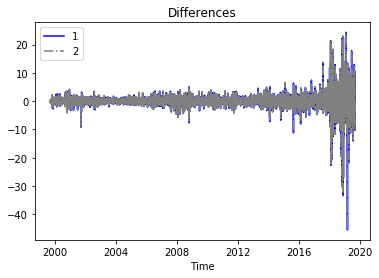

In [5]:
time_series_utils.ARIMA(series=df['open'], datetimes=df['market_datetime']).differences_plot()

/Users/rickbetzler/anaconda3/envs/babylon/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/rickbetzler/anaconda3/envs/babylon/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rickbetzler/anaconda3/envs/babylon/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


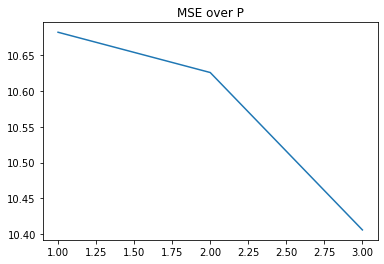

In [6]:
time_series_utils.ARIMA(series=df['open'],
          datetimes=df['market_datetime'], p=(1,4), d=(0,1), q=(0,1),
          forecast_date=('2019-08-05', '2019-08-09')).benchmark_plot()

### Time series metrics

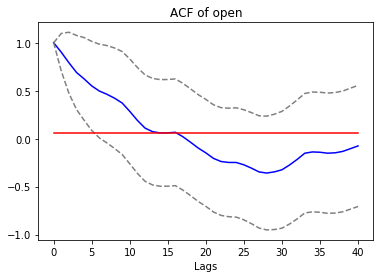

In [6]:
time_series_utils.ARIMA(series=df['open']).acf_plot()

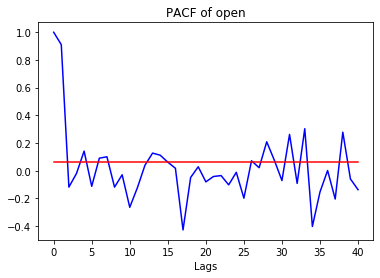

In [7]:
time_series_utils.ARIMA(series=df['open']).pacf_plot()

### ARIMA 

In [8]:
time_series_utils.ARIMA(series=df['open'], 
                        datetimes=df['market_datetime'], 
                        forecast_date='2019-08-08').model_forecast

{'forecast': 328.9383395540727,
 'aic': 23967.31809120681,
 'bic': 23993.542208067614}

In [9]:
time_series_utils.ARIMA(series=df['open'],
                        datetimes=df['market_datetime'],
                        p=3, d=2, forecast_date='2019-09-02').optimal_params

,,,aic,bic,forecast,actual,mse,mae
p,d,q,,,,,,
2,0,0,24153.236195,24179.474139,364.321438,354.11,104.273462,10.211438


# Options

In [9]:
query = """
    select *
    from td.options 
    where symbol = 'BA'
    """

options = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)

In [10]:
options[options['description'].str.contains('BA Sep 20 2019')].T

,115,116,117,118,119,120,121,122,123,124,...,995,996,997,998,999,1000,1001,1002,1003,1004
symbol,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA,...,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA
volatility,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
n_contracts,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,...,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630
interest_rate,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,...,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788
put_call,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,...,PUT,PUT,PUT,PUT,PUT,PUT,PUT,PUT,PUT,PUT
description,BA Sep 20 2019 185 Call,BA Sep 20 2019 190 Call,BA Sep 20 2019 195 Call,BA Sep 20 2019 200 Call,BA Sep 20 2019 205 Call,BA Sep 20 2019 210 Call,BA Sep 20 2019 215 Call,BA Sep 20 2019 220 Call,BA Sep 20 2019 225 Call,BA Sep 20 2019 230 Call,...,BA Sep 20 2019 460 Put,BA Sep 20 2019 465 Put,BA Sep 20 2019 470 Put,BA Sep 20 2019 475 Put,BA Sep 20 2019 480 Put,BA Sep 20 2019 485 Put,BA Sep 20 2019 490 Put,BA Sep 20 2019 500 Put,BA Sep 20 2019 520 Put,BA Sep 20 2019 540 Put
exchange_name,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,...,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR
bid,171.55,166.55,161.55,156.55,151.55,146.6,141.6,136.6,131.6,126.6,...,103.15,108.15,113.15,118.15,123.15,128.15,133.15,143.15,163.15,183.15
ask,172.05,167.05,162.05,157.05,152.1,147.1,142.1,137.1,132.1,127.1,...,103.65,108.65,113.65,118.65,123.65,128.65,133.65,143.65,163.65,183.65
last,0,170.65,163.85,131.5,0,0,0,0,133.1,101.71,...,82.84,0,0,110.85,126.6,131.5,128.1,127.8,166,184.55


### Black scholes

In [20]:
option = financial_utils.BlackScholes(
    current_stock_price=450,
    strike_price=385,
    risk_free_rate=1.025,
    days_to_maturity=60,
    volatility=.5,
    call_put='call'
)

In [21]:
print('Theoretical option price: $' + str(round(option.option_price, 2)))

Theoretical option price: $76.84


### Greeks

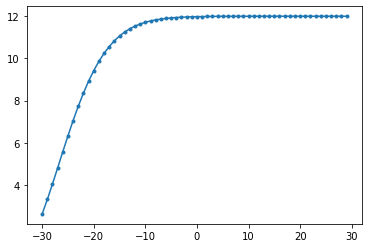

In [22]:
deltas = option.get_greek(greek='delta', steps=30)
plt.plot(deltas, marker='.')
plt.show()

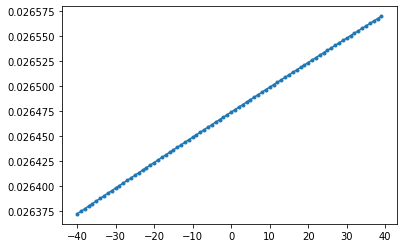

In [23]:
ros = option.get_greek(greek='ro', steps=40)
plt.plot(ros, marker='.')
plt.show()

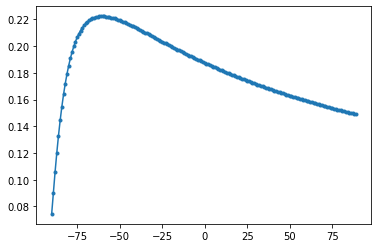

In [24]:
thetas = option.get_greek('theta', steps=90)
plt.plot(thetas, marker='.')
plt.show()

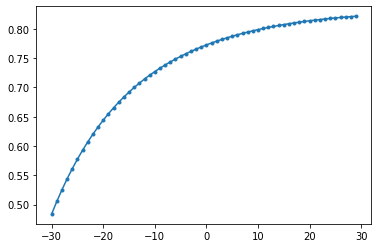

In [25]:
vegas = option.get_greek(greek='vega', steps=30)
plt.plot(vegas, marker='.')
plt.show()

In [40]:
chain = options[options['description'].str.contains('BA Sep 20 2019')]
chain = options[(options['description'].str.contains('BA Sep 20 2019')) & (options['put_call']=='CALL')]

In [41]:
chain.head(1).T

,115
symbol,BA
volatility,29
n_contracts,1630
interest_rate,2.42788
put_call,CALL
description,BA Sep 20 2019 185 Call
exchange_name,OPR
bid,171.55
ask,172.05
last,0


### Implied volatility

In [53]:
imp_vols = []
current_stock_price = 354.42
risk_free_rate=1.025
volatility=.5
for idw, row in options.iterrows():
    imp_vol = financial_utils.BlackScholes(
        current_option_price=row['close_price'],
        current_stock_price=current_stock_price,
        strike_price=row['strike'],
        risk_free_rate=risk_free_rate,
        days_to_maturity=row['days_to_expiration_date'],
        volatility=volatility,
        call_put=row['put_call'].lower()
    ).implied_volatility
    imp_vols.append(imp_vol)


2019-09-13 04:10:13
2019-09-13 04:10:17


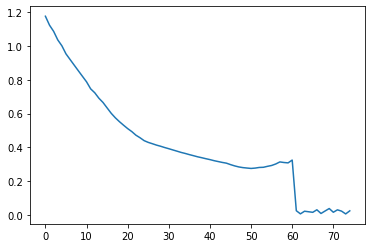

In [43]:
imp_vols = pd.DataFrame(imp_vols)
plt.figure()
plt.plot(imp_vols)
plt.show()